<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC3: Deep Reinforcement Learning (II)

L'objectiu d'aquesta pràctica és utilitzar la llibreria [stable baselines 3](https://stable-baselines3.readthedocs.io/en/master/), que ja te implementats algoritmes d'aprenentatge per reforç, per solucionar una versió modificada del cartpole, anomenada cartpole target. Els objectius d'aquesta pràctica són:
<ol>
    <li>Desenvolupar una capacitat analítica sobre com està funcionant el model.</li>
    <li>Familiaritzar-se amb la llibreria stable baselines 3.</li>
    <li>Analitzar l'efecte de modificar la funció de recompensa durant l'entrenament de l'agent.</li>
    <li>Analitzar l'efecte de modificar l'espai d'accions.</li>
    <li>Ser capaços de realitzar una cerca d'hiperparàmetres.</li>
    <li>(Opcional) Familiaritzar-se amb l'anàlisi mitjançant tensorboard.</li>
</ol>

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File → Download as → HTML.**


# 0. Cartpole target (2 punts)

En aquesta pràctica utilitzarem un entorn anomenat cartpole random target. Aquest entorn està fora de la llibreria gymnasium i és una modificació de l'entorn [cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). En aquest entorn, l'objectiu no només és mantenir el pal estable, sinó que el carro ha d'estar el més a prop possible d'un punt objectiu, el qual es pot observar marcat en verd quan es renderitza l'entorn:

![image.png](attachment:image.png)

Hi ha alguns paràmetres en l'entorn que permeten regular com de rellevant volem que sigui el punt objectiu, fins al punt que podem aconseguir que aquesta modificació es comporti com el cartpole original.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.1 (0.75 punts):</strong> Llegeix el codi de l'entorn que es proporciona a continuació detingudament. Ignoreu tots els TODOS, són coses que haurem d'implementar a mesura que la pràctica avanci. Després, responeu les següents preguntes:
    <ul>
      <li>Quin és l'espai d'observacions? Com es distingeix respecte a la versió bàsica de cartpole?</li>
      <li>Quines dues versions de la reward existeixen en l'entorn?</li>
      <li>Per al cas en que la reward és custom, què fa el paràmetre target_desire_factor?</li>
    </ul>
</div>


In [1]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn és d'avaluació
        self.is_eval = is_eval
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn és d'avaluació per situar el target en unes posicions concretes.
            raise NotImplementedError("You should implement is_eval casuistic")
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posició aleatòria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
1.**Espai d'observacions**: 
   
L'espai d'observacions es tracta d'una caixa (Box) amb els límits següents:
    
* Posició del carro: entre -4.8 i 4.8.
* Velocitat del carro: entre -infinit i infinit.
* Angle del pal: entre -24º i 24º (radians).
* Velocitat angular del pal: entre -infinit i infinit.
* Posició del target: entre -4.8 i 4.8.
    
Definició, creació i assiganció dels límits de l'espai d'observació:
    
```
#Definition    
high = np.array(
    [
        self.x_threshold * 2,  # Límit per la posició del carro
        np.inf,                # Límit per la velocitat del carro
        self.theta_threshold_radians * 2,  # Límit per l'angle del pal
        np.inf,                # Límit per la velocitat angular del pal
        self.target_threshold * 2,  # Límit per la posició del target
    ],
    dtype=np.float32,
)

#Creation
self.observation_space = spaces.Box(-high, high, dtype=np.float32)
    
#Assignment
self.state = np.array(
    (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
)
    
```
    
Aquest espai d'observacions es distingeix de la versió bàsica de 'cartpole' perquè inclou la posició del target com a una dimensió addicional. La versió original inclou 4 elements: posició del carro, velocitat del carro, angle del pal i velocitat del pal. 
    
2.**Reward**:
    
Hi ha dues versions de la funció de recompensa en aquest entorn:
    
* _Default_ : Recompensa similar a la de la versió bàsica del 'cartpole'. La recompensa és 1 per a cada pas que el pal es manté dret i no ha acabat l'episodi.
    
```
if self.reward_function == "default":
    return 1 if not terminated else 0
```

* _Custom_ : La recompensa es calcula considerant la proximitat al target i l'angle del pal. Es calcula de la següent manera: 

```
angle_reward = (
    -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
)
target_reward = -(abs(target_position - current_position) ** 2) / (
    (2 * self.x_threshold) ** 2
)
return (
    1
    + self.target_desire_factor * target_reward
    + (1 - self.target_desire_factor) * angle_reward
)
```    
    
Quan ens trobem en el cas de la recompensa custom, el paràmetre 'target_desire_factor' determina el pes relatiu entre la proximitat al target i l'angle del pal. Un valor més alt fa que la recompensa depengui més de la proximitat al target, mentre que un valor més baix fa que la recompensa depengui més de l'angle del pal. 
  

</div>

<strong>IMPORTANT: PER ALS APARTATS 1 I 2 FAREM SERVIR LA REWARD DEFAULT.</strong> Això implica que el nostre entorn serà el mateix que el del cartpole clàssic sense target.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.2 (0.75 punts):</strong> Executa l'entorn cartpole target utilitzant una policy random. Desa les observacions en una llista i posteriorment crea una funció per analitzar els resultats on es vegi:
    <ul>
    <li>Un scatter plot dels angles del pal així com la posició relativa del carro respecte al target. Heu de marcar el punt inicial i final. De manera opcional, podeu marcar cada punt de forma diferent segons l'acció presa (empujar a l'esquerra o a la dreta). Per exemple, una creu si es prem a la dreta i un cercle si es fa cap a l'esquerra).</li>
    <li>L'evolució de la reward.</li>
    <li>Imprimir el número de steps realitzats.</li>
    </ul>
Comenta els resultats trobats.

<strong>NOTA: Per poder veure com l'agent va movent el Pal de manera interactiva, podeu utilitzar render_mode = 'human'. Això NO s'ha de fer quan s'entrenin els models, ja que seran molt lents d'entrenar.
    
No és obligatori utilitzar render_mode = 'human' per a les avaluacions, però pot ser interessant. En cas de voler-ho fer, recordeu que cal executar-ho localment.</strong>
</div>



In [2]:
import gymnasium as gym
import time

In [3]:
#TODO: Completar codi
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default')

#Init variables
observations = []
current_step = [] #temporary storage
rewards = []
actions = []
steps = 0

#Reset env
state, _ = env.reset()
done = False

while not done:
    #random action
    action = env.action_space.sample() 
    actions.append(action) #save action

    #Info before step
    print(f"Step: {steps}, Action: {action}, State: {state}")

    #execute action
    next_state, reward, terminated, truncated, _ = env.step(action)

    #Status after step
    print(f"Next State: {next_state}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}\n")

    current_step.append((state,action)) #save temporary state-action pair
    rewards.append(reward)#save reward
    
    #Check episode end
    if terminated or truncated:
        print("Episode ended.")
        done = True
        observations.append(current_step)
        break
        
    steps += 1 #increase steps
    state = next_state #next state to current state for next step

#Close env
env.close()

#Print steps
print(f"Number of steps taken: {steps}")

# # Print the values of observations and rewards
# print("\nObservations:")
# for episode in observations:
#     for step in episode:
#         print(step)

# print("\nRewards:")
# print(rewards)

# Convertim les observacions a un format numpy per facilitar l'anàlisi
observations = np.array(observations, dtype=object) 
rewards = np.array(rewards)

Step: 0, Action: 1, State: [-0.03132387 -0.0012875   0.03104901  0.02406318 -0.6041395 ]
Next State: [-0.03134962  0.19337574  0.03153027 -0.25866398 -0.6041395 ], Reward: 1, Terminated: False, Truncated: False

Step: 1, Action: 0, State: [-0.03134962  0.19337574  0.03153027 -0.25866398 -0.6041395 ]
Next State: [-0.02748211 -0.00218182  0.02635699  0.04379491 -0.6041395 ], Reward: 1, Terminated: False, Truncated: False

Step: 2, Action: 1, State: [-0.02748211 -0.00218182  0.02635699  0.04379491 -0.6041395 ]
Next State: [-0.02752574  0.19255246  0.02723289 -0.240457   -0.6041395 ], Reward: 1, Terminated: False, Truncated: False

Step: 3, Action: 0, State: [-0.02752574  0.19255246  0.02723289 -0.240457   -0.6041395 ]
Next State: [-0.02367469 -0.00294772  0.02242375  0.06069001 -0.6041395 ], Reward: 1, Terminated: False, Truncated: False

Step: 4, Action: 1, State: [-0.02367469 -0.00294772  0.02242375  0.06069001 -0.6041395 ]
Next State: [-0.02373365  0.19184567  0.02363755 -0.22483458 -0

In [4]:
import numpy as np
import matplotlib.pylab as plt
X_THRESHOLD = env.unwrapped.x_threshold*1.25 #Limit de posicio del carro
ANGLE_THRESHOLD = env.unwrapped.theta_threshold_radians*1.25 #Limit de l'angle del pal
def analyze_results(observations, rewards):
    for step_idx, step in enumerate(observations):
        #Extract positions, angles and actions
        positions = [obs[0][0] for obs in step] #relative position to the target
        angles = [obs[0][2] for obs in step] #pole angles
        actions = [obs[1] for obs in step] #actions

        #Scatter plot
        plt.figure(figsize=(10, 6))
        for pos, angle, action in zip(positions, angles, actions):
            marker = 'x' if action == 1 else 'o'  #X right | O left
            plt.scatter(pos, angle, c='blue', marker=marker, alpha=0.7)

        #Highlight start and end points
        plt.scatter(positions[0], angles[0], c='green', label='Start', s=100) #start piont
        plt.scatter(positions[-1], angles[-1], c='red', label='End', s=100) #end point

        # Customize plot
        plt.xlabel('Position relative to target')
        plt.ylabel('Pole angle (radians)')
        plt.title(f'Distance-Angle Trajectory (Step {step_idx + 1})')
        plt.ylim(-ANGLE_THRESHOLD, ANGLE_THRESHOLD)
        plt.xlim(-X_THRESHOLD, X_THRESHOLD)
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
        plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    #Reward evolution plot
    cumulative_rewards = np.cumsum(rewards) #cumulative reward
    
    #lines
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(rewards)), rewards, marker='o', linestyle='-', color='orange', alpha=0.8, label='Step Reward')
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards, marker='s', linestyle='--', color='blue', alpha=0.8, label='Cumulative Reward')
    #annotations
    plt.text(len(rewards) - 1, rewards[-1] + 0.1, 'Step Reward', color='orange', fontsize=10)
    plt.text(len(cumulative_rewards) - 1, cumulative_rewards[-1] + 0.1, 'Cumulative Reward', color='blue', fontsize=10)
    
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.title('Reward Evolution')
    plt.grid(alpha=0.3)
    plt.show()

    #print steps
    print(f'Number of steps taken: {steps}')

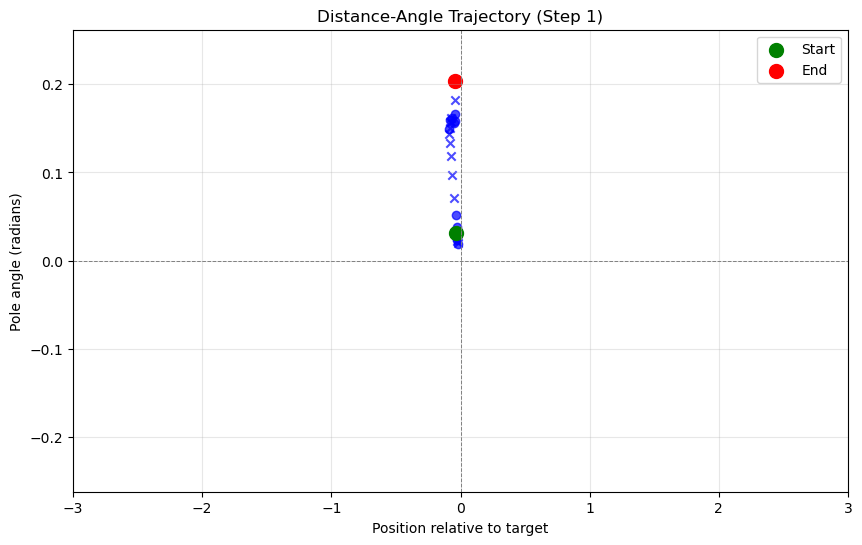

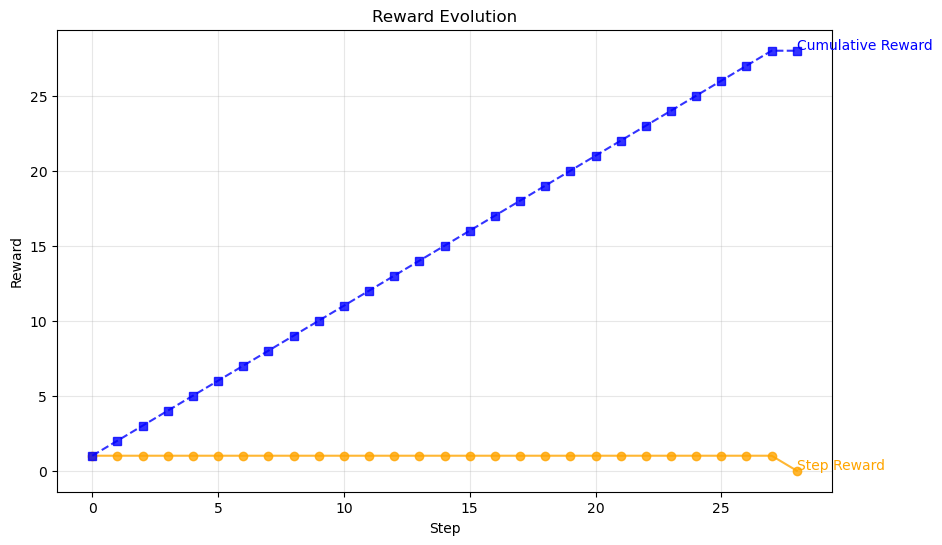

Number of steps taken: 28


In [5]:
# TODO: passar inputs necessaris
analyze_results(observations, rewards)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Distance - Angle plot 

Pel fa a la posició respecte a l'objectiu, la trajectòria es manté a prop del x=0. Això indica que el carro s'ha mantingut gairebé centrat en relació amb l'objectiu, suggerint un control estable sobre el moviment del carro. L'angle del pole oscil·la lleugerament per sobre i sota 𝜃 = 0 (posició vertical), però dins d'un rang petit. El sistema manté el pal prop de la vertical durant els passos. Respecte a les accions realitzades (x -> empènyer carro dreta, o -> empènyer carro esquerra), veiem que l'agent alterna entre empentar esquerra i dreta de manera alterna per mantenir l'estabilitat.

#### Reward plot

La recompensa del pas es manté constant en 1 per a tots els passos, cosa que demostra que l'agent manté constantment un entorn estable (ni falla ni es desvia massa). Pel que a la recompensa acumulada, aquesta augmenta linealment amb el nombre de passos, reflectint l'acumulació consistent de recompensa de passos. Això indica que l'episodi avança sense finalitzar, mantenint el sistema de cart-pole equilibrat per a tots els passos observats.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 0.3 (0.5 punts):</strong> Respecte al gràfic realitzat a l'apartat anterior, quina seria la trajectòria que realitzaria un agent que es comportés de manera òptima?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
Un agent òptim que mantingués el control perfecte del sistema CartPole hauria de presentar les següents característiques: 

1.**Posició relativa al target (eix x)**: 
    Mantenir la posició del carro molt pròxima a 0, és a dir, el centre del límit de posició.

2.**Angle del pal (eix y)**:
    L'angle del pal ha d'estar molt pròxim a 0 radians (completament vertical). Realitzar microajustaments per assegurar que el pal no oscil·li gaire, mantenint l'equilibri de forma contínua.

3.**Accions**:
    L'agent òptim ha de realitzar un nombre mínim d'accions per mantenir el sistema estable.

4.**Punts inicial i final**:
    Tant el punt inicial com el punt final haurien de ser molt pròxims o idèntics a x=0 i 𝜃=0. La trajectòria òptima mostraria gairebé una línia recta o un punt fix.

</div>

# 1. Stable baselines 3 (2 pts)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    Comencem a entrenar un model per solucionar l'entorn. Recordeu que per als apartats 1 i 2 utilitzarem la reward default.
    Per solucionar l'entorn, utilitzarem el model A2C de la llibreria stable baselines.
</div>


In [6]:
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
STEPS = 20_000
EVAL_FREQ = 2000
EVAL_EPISODES = 5

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.1 (0.25 punts):</strong> Entrena un model A2C amb paràmetres default i utilitzant una MlpPolicy per entrenar un agent que solucioni el cartpole amb reward default.
    Afegeix un callback per avaluar el model 5 vegades cada 2 mil iteracions.
    A més, fes que cada vegada que es trobi un model millor, es guardi el model. Inicialment, abans de començar l'entrenament, utilitza la funció evaluate_policy per avaluar el model sense entrenar. Utilitza també la funció evaluate_policy just abans d'entrenar el model per tenir una idea de com funciona el model abans de ser entrenat.
</div>


Opcional: Per a aquells que vulgueu aprofundir una mica més en l'assignatura, també existeix una eina anomenada TensorBoard, molt útil per analitzar el procés d'entrenament de qualsevol xarxa neuronal en general. Stable Baselines 3 té automatitzada la captura de logs amb TensorBoard. Per fer-ho, només cal que passeu al constructor del model el paràmetre tensorboard_log=path on vulgueu guardar el log. Podeu utilitzar aquests logs per veure no només les rewards d'evaluació, sinó també per veure els gradients, la loss i altres paràmetres durant l'entrenament.

Podeu utilitzar-lo en aquest apartat i en tots els que vulgueu durant la pràctica. No puntuïarà ni es tindrà en compte, però permet conèixer més en detall com s'està entrenant el model.

In [7]:
env = CartPoleEnvRandomTarget(render_mode=None, reward_function = 'default')

#best model save path
model_save_path = "./best_a2c_model"

#carregar callback
#callback = 
callback = EvalCallback(
    env,  # Environment for evaluation
    best_model_save_path=model_save_path,  # Directory to save the best model
    log_path=model_save_path,  # Log directory
    eval_freq=EVAL_FREQ,  # Evaluate the model every EVAL_FREQ steps
    n_eval_episodes=EVAL_EPISODES,  # Number of episodes for each evaluation
    deterministic=True,  # Use deterministic actions for evaluation
    render=False  # Don't render during evaluation
)

#carregar model
model = A2C('MlpPolicy', env, verbose=1)

#avaluació inicial
#initial_eval = 
initial_eval = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print(f"Initial evaluation before training: Mean reward = {initial_eval[0]:.2f}, Std reward = {initial_eval[1]:.2f}")

#TODO: entrenar model
model.learn(total_timesteps=STEPS, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\xavim\anaconda3\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Initial evaluation before training: Mean reward = 105.00, Std reward = 80.45
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.3     |
|    ep_rew_mean        | 9.33     |
| time/                 |          |
|    fps                | 858      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.105   |
|    explained_variance | 0.243    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0596   |
|    value_loss         | 7.72     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.4     |
|    ep_rew_mean        | 9.35     |
| time/                 |          |
|    fps                | 850      |
|    iterations         | 200      |
|    time_elapsed       | 1        

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.8     |
|    ep_rew_mean     | 41.8     |
| time/              |          |
|    fps             | 829      |
|    iterations      | 1200     |
|    time_elapsed    | 7        |
|    total_timesteps | 6000     |
---------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 46.3     |
|    ep_rew_mean        | 45.3     |
| time/                 |          |
|    fps                | 830      |
|    iterations         | 1300     |
|    time_elapsed       | 7        |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -0.573   |
|    explained_variance | 0.003    |
|    learning_rate      | 0.0007   |
|    n_updates          | 1299     |
|    policy_loss        | 1.09     |
|    value_loss         | 2.55     |
------------------------------------
---------

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 75.5     |
|    ep_rew_mean     | 74.5     |
| time/              |          |
|    fps             | 771      |
|    iterations      | 2400     |
|    time_elapsed    | 15       |
|    total_timesteps | 12000    |
---------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 80.6      |
|    ep_rew_mean        | 79.6      |
| time/                 |           |
|    fps                | 774       |
|    iterations         | 2500      |
|    time_elapsed       | 16        |
|    total_timesteps    | 12500     |
| train/                |           |
|    entropy_loss       | -0.532    |
|    explained_variance | -2.15e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 2499      |
|    policy_loss        | 0.0163    |
|    value_loss         | 0.000645  |
------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 116      |
|    ep_rew_mean     | 115      |
| time/              |          |
|    fps             | 765      |
|    iterations      | 3600     |
|    time_elapsed    | 23       |
|    total_timesteps | 18000    |
---------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 113      |
|    ep_rew_mean        | 112      |
| time/                 |          |
|    fps                | 768      |
|    iterations         | 3700     |
|    time_elapsed       | 24       |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -0.475   |
|    explained_variance | -0.00831 |
|    learning_rate      | 0.0007   |
|    n_updates          | 3699     |
|    policy_loss        | 0.0142   |
|    value_loss         | 0.000507 |
------------------------------------
-------------------------------

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.2 (0.25 punts):</strong> Carrega el millor model trobat i executa la funció evaluate_policy. Compara les rewards inicials i finals.
    Executa un episodi i analitza els resultats utilitzant la funció prèviament creada per visualitzar el comportament de l'agent en l'espai d'angle-posició.
</div>


In [8]:
import os
#best model path
best_model_path = "./best_a2c_model/best_model.zip"

#carregar el millor model
if os.path.exists(best_model_path):
    model = A2C.load(best_model_path)
    print("El millor model ha estat carregat correctament.")
else:
    raise FileNotFoundError(f"No s'ha trobat el model a {best_model_path}")

#avaluació final
final_eval = final_eval = evaluate_policy(model, env, n_eval_episodes=EVAL_EPISODES, deterministic=True)
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')
print(f"Recompensa final mitjana: {final_eval[0]:.2f} +/- {final_eval[1]:.2f}")

El millor model ha estat carregat correctament.
Initial evaluation: (105.0, 80.44874144447506)
Best model evaluation: (246.4, 130.65465931224958)
Recompensa final mitjana: 246.40 +/- 130.65


In [9]:
#TODO: Completar funcio d'avaluació del model entrenat
def evaluate_trained_model(env,model):
    #Primer executem un cop l'entorn
    obs,_ = env.reset()
    done = False
    
    #Init variables
    observations = []
    rewards = []
    step = []

    while not done:
        # TODO: Escollir accio en base al model
        action, _ = model.predict(obs, deterministic=True)

        # TODO: Executar accio i esperar resposta de l'entorn
        next_obs, reward, terminated, truncated, _ = env.step(action)

        # TODO: Guardar informacio necesaria per a poder fer les grafiques despres
        step.append((obs, action))
        rewards.append(reward)
        
        #update state and check end
        obs = next_obs
        done = terminated or truncated
        
    observations.append(step)

    #Analitzem resultats
    analyze_results(observations,rewards)
    print(f"Total Reward: {sum(rewards)}")

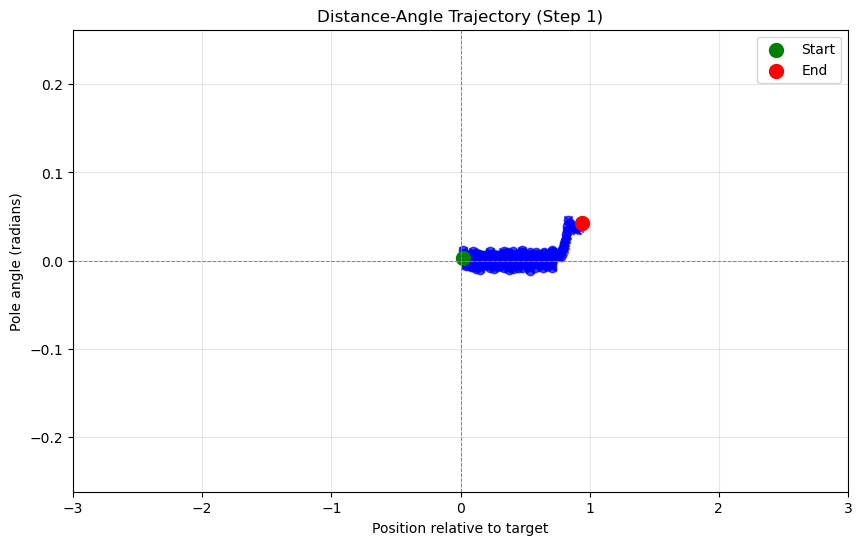

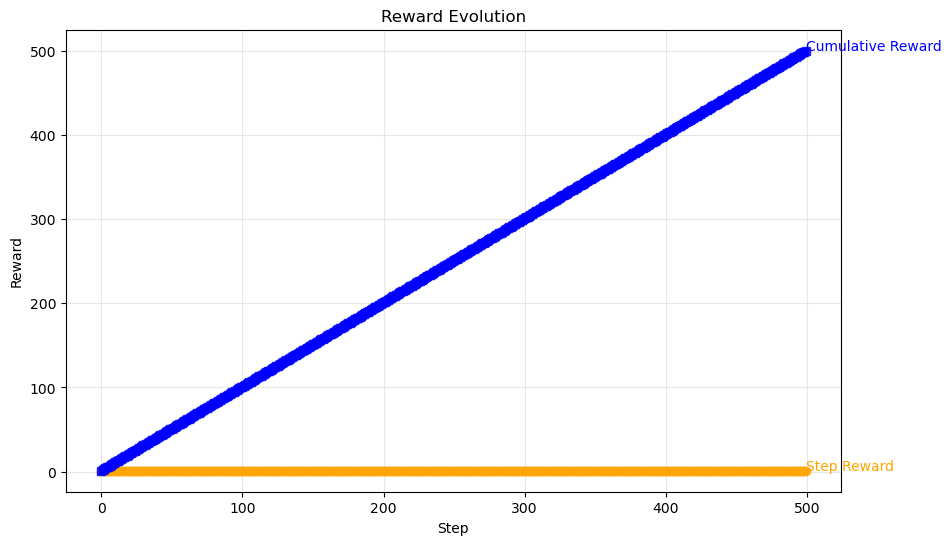

Number of steps taken: 28
Total Reward: 500


In [10]:
env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default') #podeis hacer render mode = None
evaluate_trained_model(env,model)

env.close()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
    
#### Distance - Angle plot 
La trajectòria mostra que el pal s'ha mogut amb una oscil·lació reduïda al voltant del centre (target), mantenint l'angle sota control durant tot el temps. L'agent ha sigut capaç de mantenir el balanç i controlar la posició del carro. Tot i això, les oscil·lacions són visibles i indiquen que l'agent ho ha trobat una trajectòria òptima completament estable. 

#### Reward plot
    
La recompensa acumulativa mostra una línia amb una pujada constant, suggerint que l'agent acumula punts a cada pas sense fallar durant els episodis. 


    
    
Com a conclusions finals podem dir que l'agent ha tingut un control efectiu amb algunes oscil·lacions en la trajectòria de posició i angle que mostren que hi ha marge de millora, però amb un bon rendiment general. 
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.3 (0.5 punts):</strong> Un dels problemes que tenim amb aquest entorn és que estem avaluant el model sobre un entorn random. Això genera que durant el callback puguem guardar un model no perquè sigui millor que els anteriors, sinó perquè els entorns sobre els quals s'ha avaluat són més senzills. Per exemple, si en un dels callbacks el target es situa als extrems, tot i que l'agent es comporti millor que les seves versions anteriors, potser no ho sabrem perquè la reward total serà més petita que, per exemple, una versió amb un comportament pitjor, però en què el target s'ha situat al centre.
    Modifica l'entorn de cartpole (veure TODOS dins del codi) perquè en avaluació el target es trobi en 9 posicions diferents:
    <ul>
    <li> Als extrems</li>
    <li> A 3/4, 1/2 i 1/4 de la distància entre el centre i els extrems</li>
    <li> Just al centre</li>
    </ul>
    Setejarem a partir d'ara el número d'episodis d'avaluació a 18 (EVAL_EPISODES) perquè s'executi 2 vegades cada casuística.
</div>


In [11]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled



class CartPoleEnvRandomTarget(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to a modification of the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
     The modification consists on a target appearing into scene. The cart must be as close to the target as posible

    For more details about original cartpole look for source code in gymnasium.
    """


    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
        target_desire_factor: float = 0.5,
        reward_function: str = "default",
        is_eval=False,
        increased_actions=False,
        render_mode: Optional[str] = None,
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        self.max_steps = 500
        self.steps = 0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.target_threshold = 2

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
                self.target_threshold * 2,
            ],
            dtype=np.float32,
        )
        self.increased_actions = increased_actions
        if self.increased_actions:
            #TODO 3.1: Ampliar l'espai d'observacions
            raise NotImplementedError("Increased actions should be implemented")
        else:
            self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None

        #TODO 1.3: Tenir en compte si l'entorn és d'avaluació
        self.is_eval = is_eval
        self.target_position_index = None #index to control target position
        self.target_position = self.generate_random_target_position()

        self.target_desire_factor = min(
            max(target_desire_factor, 0), 1
        )  # between 0 and 1
        if reward_function in ["default", "custom"]:
            self.reward_function = reward_function
        else:
            raise AttributeError("reward function must be either default or custom")

    def generate_random_target_position(
        self,
    ):
        if self.is_eval:
            #TODO 1.3:Tingueu en compte si l'entorn és d'avaluació per situar el target en unes posicions concretes.
            #preset target positions for evaluation mode
            eval_positions = [
                -self.x_threshold,                      # Extrem esquerre
                -self.x_threshold * 0.75,               # 3/4 esquerre
                -self.x_threshold * 0.5,                # 1/2 esquerre
                -self.x_threshold * 0.25,               # 1/4 esquerre
                0.0,                                    # Centre
                self.x_threshold * 0.25,                # 1/4 dret
                self.x_threshold * 0.5,                 # 1/2 dret
                self.x_threshold * 0.75,                # 3/4 dret
                self.x_threshold                        # Extrem dret
            ]
            #select a random position (first execution)
            if self.target_position_index is None:
                self.target_position_index = np.random.randint(0,9)

            #select the target position based on the index
            target_position = eval_positions[self.target_position_index]

            #update the index
            self.target_position_index = (self.target_position_index + 1) % 9
            
            return target_position
        else:
            return np.random.uniform(-self.x_threshold, self.x_threshold)

    def custom_reward(self, target_position, current_position, angle, terminated):
        if self.reward_function == "default":
            #Reward default del cartpole
            return 1 if not terminated else 0
        else:
            angle_reward = (
                -abs(angle) / (2.0 * self.x_threshold) / self.theta_threshold_radians
            )
            target_reward = -(abs(target_position - current_position) ** 2) / (
                (2 * self.x_threshold) ** 2
            )
            return (
                1
                + self.target_desire_factor * target_reward
                + (1 - self.target_desire_factor) * angle_reward
            )
        #TODO 2.2: Implementar 2 funcions de reward extra

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot, _ = self.state
        if self.increased_actions:
            force_factor = action - 3
            force = (
                force_factor / 3 * self.force_mag
                if force_factor > 0
                else (force_factor - 1) / 3 * self.force_mag
            )
        else:
            force = self.force_mag if action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array(
            (x, x_dot, theta, theta_dot, self.target_position), dtype=np.float64
        ) #Aquest estat es diferent respecte al del cartpole original

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        reward = self.custom_reward(self.target_position, x, theta, terminated)

        if self.render_mode == "human":
            self.render()

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        self.steps += 1
        if self.steps >= self.max_steps:
            truncated = True
        else:
            truncated = False
        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):

        super().reset(seed=seed)
        self.steps = 0
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high

        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).tolist()
        self.steps_beyond_terminated = None

        #Generar posició aleatòria del target i guardar en l'estat
        self.target_position = self.generate_random_target_position()
        self.state.append(self.target_position)

        self.state = np.array(self.state)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[classic-control]"`'
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0
        targetwidth = 10
        targetheight = 10

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        l, r, t, b = (
            -targetwidth / 2,
            targetwidth / 2,
            targetheight / 2,
            -targetheight / 2,
        )
        axleoffset = targetheight / 4.0
        targetx = x[-1] * scale + self.screen_width / 2.0  # MIDDLE OF target
        targety = 90  # TOP OF target
        target_coords = [(l, b), (l, t), (r, t), (r, b)]
        target_coords = [(c[0] + targetx, c[1] + targety) for c in target_coords]
        gfxdraw.aapolygon(self.surf, target_coords, (10, 255, 10))
        gfxdraw.filled_polygon(self.surf, target_coords, (10, 255, 10))

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.1 (0.5 punts):</strong> Modifica la funció analyze_results perquè creï els mateixos gràfics que es generaven abans però per a cada casuística. Suposa que a la funció li arribaran 9 episodis diferents, 1 per a cada casuística. Podeu utilitzar subplots de matplotlib. Us hauria de quedar alguna cosa així:
</div>


![image-3.png](exemple_sortida.png)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 1.4.2 (0.5 punts):</strong> Repeteix els exercicis 1.1 i 1.2 però avaluant amb un entorn d'avaluació i utilitzant la nova funció d'avaluació. Recorda que tot i que els EVAL_EPISODES són 18, per avaluar l'agent i fer els gràfics executarem 1 vegada cada casuística, fent un total de 9 execucions.
</div>


In [ ]:
#Modificar primer els TODOS de l'entorn
EVAL_EPISODES = 18
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default')
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'default',is_eval = True)

#TODO: Completar codi
#Creem callback i model. Per al callback farem servir l'entorn d'evaluacio, per al model el normal
callback = ?

model = ?

#Executem evaluacio inicial
initial_eval = ?

#Entrenem model
model.

#Carreguem millor model i executem validacio final
model = ?
final_eval = ?
print (f'Initial evaluation: {initial_eval}')
print (f'Best model evaluation: {final_eval}')

In [ ]:
from tqdm import tqdm

def analyze_results():
    #TODO: Completar nova funció que genera un subplot amb una gràfica per test case



def evaluate_trained_model(env,model):
    #TODO: Completar funció

    obs,_ = env.reset()
    #Fem un for loop per tots els tests cases i guardem resultats
    n_eval_cases = 9

    for _ in tqdm(range(n_eval_cases)):
        done = False
        #Executar el primer test case i guardar
        while not done:
            pass #TODO: Completar codi
        obs,_ = env.reset()

    #Executem la funció analyze results
    analyze_results(**kwargs)

#Executem la funcio
eval_env = CartPoleEnvRandomTarget(render_mode='human',reward_function = 'default',is_eval = True) #podeis modificar el render mode a None
evaluate_trained_model(eval_env,model)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

# 2. Efecte del reward (3 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.1 (1.25 punts):</strong> Entrena un agent utilitzant diferents valors del paràmetre target_desire_factor:
    <ul>
        <li>target_desire_factor=0</li>
        <li>target_desire_factor=0.5</li>
        <li>target_desire_factor=1</li>
    </ul>

Executa un episodi amb el millor agent (recorda utilitzar els callbacks) i comenta els resultats obtinguts.
</div>


In [ ]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=)#Modificar target_desire_factor
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',target_desire_factor=,is_eval = True)#Modificar target_desire_factor

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats utilitzant la funció evaluate_trained_model.
#Repetir per a cada valor de target_desire_factor.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.2 (1.25 punts):</strong> Fixant ara target_desire_factor = 1, proposa 2 modificacions de la funció de recompensa únicament de la component que té a veure amb el target i comenta els resultats obtinguts. Utilitza la mateixa estructura que fins ara (callback, model, avaluació inicial...).
</div>


In [ ]:
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom_1',target_desire_factor=0)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom_1',target_desire_factor=0,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats.
#Repetir per a les dues noves funcions d'error.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 2.3 (0.5 punts):</strong> A nivell teòric i suposant un temps d'entrenament més llarg amb uns hiperparàmetres més òptims, podríem arribar a esperar mai d'un agent amb una alpha = 1 (només es fixa en estar a prop del target) que aprengui a mantenir el pal en equilibri?
    Sabries trobar una equivalència amb el cas sense el target?
</div>


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

# 3. Increment de l'espai d'accions (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.1 (0.5 punts):</strong> Modifica el codi de tal manera que ara existeixin 6 accions en comptes de 2:
    <ul>
    <li>Accions 6,5,4, fer un 100%, 66% i 33% de força positiva respectivament</li>
    <li>Accions 1,2,3, fer un 100%, 66% i 33% de força negativa respectivament</li>
    </ul>

<strong>NOTA: A partir d'ara i fins al final de la pràctica es farà servir la recompensa custom que ja venia implementada amb target_desire_factor = 1</strong>
</div>


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 3.2 (1 punt):</strong> Executa un entrenament i analitza els resultats. Per què han anat millor/pitjor? És el que esperaves?
</div>


In [ ]:
#implementar abans els TODO de l'entorn
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = True,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Al final, analitzar els resultats.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

# 4. Cerca d'hiperparàmetres (1.5 pts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.1 (1 punt):</strong> Utilitzant l'entorn amb desire_factor = 1 i amb les accions per defecte (no ampliades), busca els hiperparàmetres del model perquè aquest aprengui en menys de 10 mil passos. Us donem algunes pistes sobre el rang de valors que val la pena explorar:
    <ul>
    <li>gamma = (0.9,0.999). Es recomana cerca en escala logarítmica</li>
    <li>max_grad_norm = (0.3,5.0). Es recomana cerca en escala logarítmica</li>
    <li>n_steps = (8,32)</li>
    <li>learning_rate = (1e-5,1e-1). Es recomana cerca en escala logarítmica</li>
    <li>ent_coef = (1e-8,1e-3). Es recomana cerca en escala logarítmica</li>
    </ul>
    <strong>Important:</strong> La cerca d'hiperparàmetres s'ha de poder fer en 100 passos, és a dir, només caldria entrenar el model amb 100 combinacions diferents d'hiperparàmetres, res més.
    
Explica l'estratègia de cerca que s'ha seguit. Si s'utilitza una estratègia dummy tipus grid search, la puntuació màxima serà de 0.5/1 punts. Per aconseguir la màxima puntuació, podeu utilitzar frameworks com [optuna](https://optuna.org/#code_examples) per fer l'optimització d'hiperparàmetres.
</div>


In [ ]:
STEPS = 10_000 #BAIXEM ELS STEPS A 10_000 per fer la cerca més ràpida
EVAL_EPISODES = 18
EVAL_FREQ = 2_000
N_TRIALS = 100  #Només farem 100 trials amb diferents combinacions d'hiperparàmetres


In [ ]:
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

#TODO: Cerca hiperparàmetres

print ('Best hiperparams:')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Exercici 4.2 (0.5 punts):</strong> Ara torna a entrenar un model durant 30_000 passos i analitza els resultats obtinguts.
</div>

In [ ]:
STEPS = 30_000
env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1)
eval_env = CartPoleEnvRandomTarget(render_mode=None,reward_function = 'custom',increased_actions = False,target_desire_factor=1,is_eval = True)

#TODO: Repetir el mateix que en els exercicis anteriors. Callback, model, avaluació inicial, càrrega del millor model i entrenament.
#Recordeu fer servir els millors hiperparametres trobats
#Al final, analitzar els resultats.


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentari:</strong>
<br><br>
</div>